In [8]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
# from xgboost import XGBRegressor

from sklearn.metrics import r2_score
from sklearn.linear_model import HuberRegressor
from sklearn.ensemble import RandomForestRegressor
# from tsfresh import extract_features,extract_relevant_features
from sklearn.preprocessing import PolynomialFeatures

from sklearn.ensemble import AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

In [ ]:
from collections import Counter

In [184]:
def train_val_test(data, splits=[0.7,0.1,0.2],seed=42):
    '''
    
    Inputs Args: 
    
    dataa : entire labelled data available
    splits : [train_size, val_size, test_size] # fractions
    
    '''
    
    
    data_patients = data.patient_id.unique()
    
    np.random.seed(seed)
    np.random.shuffle(data_patients) # shuffle patients
    
    splits = [int(i * len(data_patients)) for i in splits]
    train_size, val_size, test_size = splits
    
    train_patients = data_patients[:train_size]
    val_patients   = data_patients[train_size : train_size + val_size]
    test_patients = data_patients[train_size + val_size : ] # we not using test_size
                                                            # but it's same
        

    assert len(train_patients) + len(val_patients) + len(test_patients)\
                    == data.patient_id.nunique()

    train = data[data.patient_id.isin(train_patients)]
    val = data[data.patient_id.isin(val_patients)]
    test = data[data.patient_id.isin(test_patients)] 
    
    return train, val, test
    

def get_arrays(train, val, test, features, target):
    ''' get Xs and Ys for machine learning'''

    X_train, y_train = train[features], train[target]
    X_val, y_val = val[features], val[target]
    X_test, y_test =  test[features], test[target]
    
    return X_train, y_train, X_val, y_val, X_test, y_test


def get_cross_validation(model, X_train, y_train, X_val, y_val, X_test, y_test
                         , mode='val',
                        use_full=True):
    '''
    Used for cross validation and getting test metrics
    
    mode = 'val' -> do cross validation
           'test' -> get test estimates
           
    use_full = whether to use combine train and val sets for test
               only used when mode = 'test'
    
    '''
    
    if mode=='val':  
        model.fit(X_train, y_train)
        train_score = r2_score(y_train, model.predict(X_train))
        val_score = r2_score(y_val, model.predict(X_val))
        return train_score, val_score
    
    if mode=='test':
        
        if use_full:
            X_full = pd.concat([X_train, X_val], axis=0)
            y_full = pd.concat([y_train, y_val], axis=0)
            model.fit(X_full, y_full)
            
            train_score = r2_score(y_full, model.predict(X_full))
            test_score = r2_score(y_test, model.predict(X_test))
            
            return train_score, test_score
        
        if not use_full:
            
#             model.fit(X_train, y_train)  # no need to train here
            
            train_score = r2_score(y_train, model.predict(X_train))
            test_score = r2_score(y_test, model.predict(X_test))
            
            return train_score, test_score

def score_model(model,ml_df, feat_xx, target_name):
    '''
    gets the stable cross validation scores for the model
    by randomly splitting patients into train and val sets
    10 times. 
    
    Inputs Args:
        
        model = ML model to use 
        
        ml_df = dataframe which has features and targets
        
        feat_xx = list of column names in ml_df to use as features
        
        target_name = column name of target in ml_df. ex: 'y_mean_MAP'
    
    
    '''
    
    train_score_list = []
    val_score_list = []
    
    for seed in range(3):
        train, val, test = train_val_test(ml_df, splits=[0.7,0.3,0],seed=seed)
        X_train, y_train, X_val, y_val, X_test, y_test = get_arrays(train,val,test,feat_xx,target_name)
        train_score, val_score = get_cross_validation(model, X_train, y_train, X_val, y_val, X_test, y_test
                                 , mode='val',
                                use_full=True)
        train_score_list.append(train_score)
        val_score_list.append(val_score)
    
    return train_score_list, val_score_list
    

In [4]:
# load data
data_path = Path('./data')
data = pd.read_csv(data_path/'train.csv')
test = pd.read_csv(data_path / 'data_for_test.csv')

In [5]:
df = data.copy()

In [6]:
df.head()

,patient_id,key,gender,age,x1,x2,x3,x4,x5,x6,xx1,xx2,xx3,xx4,xx5,y_mean_MAP,y_mean_HR
0,1891,1891-3,1,75,22,1,2,0,0,1,80.0,95.0,99.9,49.4,62.5,59.04,80.0
1,1891,1891-3,1,75,22,1,2,0,0,1,80.0,94.9,98.4,48.7,61.3,59.04,80.0
2,1891,1891-3,1,75,22,1,2,0,0,1,80.0,95.0,95.3,48.5,60.3,59.04,80.0
3,1891,1891-3,1,75,22,1,2,0,0,1,80.0,95.0,97.4,48.9,61.3,59.04,80.0
4,1891,1891-3,1,75,22,1,2,0,0,1,76.7,95.7,99.6,50.2,62.8,59.04,80.0


In [7]:
df.key = df.key.apply(lambda x: x.split('-')[-1]).astype(int)

## Create features

In [10]:
def get_static_features(dataframe):
    dataframe =  dataframe.groupby(['patient_id','key'], as_index=False).last()
    return dataframe[['patient_id','key','gender', 'age', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6']]


def get_last_row(dataframe):
    dataframe = dataframe.groupby(['patient_id','key'], as_index=False).last()
    dataframe = dataframe[['patient_id','key','xx1','xx2','xx3','xx4','xx5']]
    dataframe.columns = ['patient_id','key','xx1_last','xx2_last','xx3_last'
                         ,'xx4_last','xx5_last']
    
    return dataframe


def get_mean_features(dataframe):
    dataframe = dataframe.groupby(['patient_id','key'], as_index=False).mean()
    dataframe = dataframe[['patient_id','key','xx1','xx2','xx3','xx4','xx5']]
    
    dataframe.columns = ['patient_id','key','xx1_mean','xx2_mean',
                      'xx3_mean','xx4_mean','xx5_mean']
    return dataframe


def get_target(dataframe):
    return dataframe[['patient_id', 'key', 'y_mean_MAP', 'y_mean_HR']].drop_duplicates()

In [11]:
static = get_static_features(df)

last = get_last_row(df)
mean_df = get_mean_features(df)

static.shape, last.shape, mean_df.shape

static.columns

features = pd.merge(static, last, on = ['patient_id', 'key'])
features = pd.merge(features, mean_df, on= ['patient_id', 'key'])

targets = get_target(df)

ml_df = pd.merge(features, targets, on = ['patient_id', 'key'])

feat_xx = ['gender', 'age', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'xx1_last',
       'xx2_last', 'xx3_last', 'xx4_last', 'xx5_last', 'xx1_mean', 'xx2_mean',
       'xx3_mean', 'xx4_mean', 'xx5_mean']

target_name = 'y_mean_MAP'

## baseline linear model with avg and last row features

In [74]:
model = LinearRegression(normalize=False)

tsl,vsl = score_model(model, ml_df, feat_xx,'y_mean_MAP')

print(np.mean(tsl), np.std(tsl))

print(np.mean(vsl), np.std(vsl))

0.8945192895702773 0.001810143578798839
0.8930717345014827 0.003934449412401173


In [26]:
ml_df.head()

,patient_id,key,gender,age,x1,x2,x3,x4,x5,x6,...,xx3_last,xx4_last,xx5_last,xx1_mean,xx2_mean,xx3_mean,xx4_mean,xx5_mean,y_mean_MAP,y_mean_HR
0,0,28,0,72,39,5,1,0,0,0,...,112.0,71.0,88.0,80.166667,99.733333,113.433333,69.566667,87.000000,86.426667,79.130000
1,1,5,1,64,55,9,5,1,0,1,...,96.0,52.0,68.0,62.633333,100.000000,104.000000,55.033333,72.433333,68.430000,58.456667
2,1,6,1,64,55,9,5,1,0,1,...,98.0,56.0,72.0,57.633333,100.000000,95.766667,53.300000,69.200000,70.746667,58.480000
3,1,7,1,64,55,9,5,1,0,1,...,107.0,57.0,75.0,61.633333,99.133333,102.600000,57.266667,73.933333,76.350000,63.556667
4,1,8,1,64,55,9,5,1,0,1,...,113.0,58.0,76.0,60.300000,97.866667,110.433333,57.566667,75.600000,76.690000,59.250000


In [30]:
l = ml_df.key.to_list()

In [34]:
d = Counter(l)

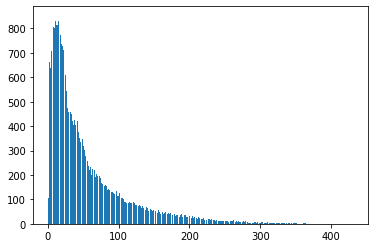

In [36]:
_ = plt.bar(x=d.keys(),height=d.values())

In [47]:
set(range(1,431)) - set(sorted(d.keys()))

{352,
 358,
 371,
 375,
 376,
 377,
 378,
 379,
 380,
 381,
 382,
 383,
 384,
 385,
 386,
 387,
 388,
 389,
 390,
 391,
 392,
 393,
 394,
 395,
 396,
 397,
 398,
 399,
 400,
 401,
 402,
 403,
 404,
 405,
 406,
 407,
 408,
 409,
 410,
 411,
 412,
 413,
 414,
 415,
 416,
 417,
 418,
 419,
 420,
 421,
 422,
 423,
 424,
 425,
 426,
 427,
 428}

## newer version

In [110]:
prev_key = last.groupby('patient_id')['xx1_last', 'xx2_last', 'xx3_last', 'xx4_last', 'xx5_last'].shift(1)
prev_key.columns = [i+'_lag' for i in prev_key.columns ]

In [ ]:
# prev_key.fillna(prev_key.mean(), inplace=True)

In [115]:
latest = pd.concat([ml_df, prev_key], axis=1)

In [116]:
latest.head()

,patient_id,key,gender,age,x1,x2,x3,x4,x5,x6,...,xx3_mean,xx4_mean,xx5_mean,y_mean_MAP,y_mean_HR,xx1_last_lag,xx2_last_lag,xx3_last_lag,xx4_last_lag,xx5_last_lag
0,0,28,0,72,39,5,1,0,0,0,...,113.433333,69.566667,87.000000,86.426667,79.130000,NaN,NaN,NaN,NaN,NaN
1,1,5,1,64,55,9,5,1,0,1,...,104.000000,55.033333,72.433333,68.430000,58.456667,NaN,NaN,NaN,NaN,NaN
2,1,6,1,64,55,9,5,1,0,1,...,95.766667,53.300000,69.200000,70.746667,58.480000,57.0,100.0,96.0,52.0,68.0
3,1,7,1,64,55,9,5,1,0,1,...,102.600000,57.266667,73.933333,76.350000,63.556667,59.0,100.0,98.0,56.0,72.0
4,1,8,1,64,55,9,5,1,0,1,...,110.433333,57.566667,75.600000,76.690000,59.250000,62.0,98.0,107.0,57.0,75.0


In [120]:
for col in ['xx1_last', 'xx2_last', 'xx3_last', 'xx4_last', 'xx5_last']:
    lag_col = col+'_lag'
    latest.loc[latest[lag_col].isna(), lag_col] = latest.loc[latest[lag_col].isna(), col]

In [146]:
proxy = latest.copy()

proxy = proxy[proxy.x1.isin(set(test.x1))]

proxy = proxy[proxy.x2.isin(set(test.x2))]

proxy.shape

(43247, 27)

mean, last and lag featues with only subset of train data
> Improved upon baseline model 

In [130]:
from sklearn.ensemble import GradientBoostingRegressor

In [167]:

model = RandomForestRegressor(n_estimators=200, max_depth=7,
                             n_jobs=-1)

# model = GradientBoostingRegressor(n_estimators=200, max_depth=5, subsample=0.5)

fs = [ 'gender', 'age', 'x1', 'x2', 'x3', 'x4', 'x5',
       'x6', 'xx1_last', 'xx2_last', 'xx3_last', 'xx4_last', 'xx5_last',
       'xx1_mean', 'xx2_mean', 'xx3_mean', 'xx4_mean', 'xx5_mean',
        'xx1_last_lag', 'xx2_last_lag',
       'xx3_last_lag', 'xx4_last_lag', 'xx5_last_lag']

# model = LinearRegression()

tsl,vsl = score_model(model, proxy, fs,'y_mean_MAP')

print(np.mean(tsl), np.std(tsl))

print(np.mean(vsl), np.std(vsl))

0.9020957689424861 0.0024751692589182477
0.9001189265493504 0.004135406173044343


## Next model
1. add standard deviation

In [157]:
def get_std_features(dataframe):
    dataframe = dataframe.groupby(['patient_id','key'], as_index=False).agg(\
                            {'xx1':'std', 'xx2':'std', 'xx3':'std', 
                            'xx4':'std', 'xx5':'std'})
    
    dataframe.columns = ['patient_id','key','xx1_std','xx2_std',
                      'xx3_std','xx4_std','xx5_std']
    return dataframe

In [158]:
std_df = get_std_features(df)

In [159]:
proxy.head()

,patient_id,key,gender,age,x1,x2,x3,x4,x5,x6,...,xx3_mean,xx4_mean,xx5_mean,y_mean_MAP,y_mean_HR,xx1_last_lag,xx2_last_lag,xx3_last_lag,xx4_last_lag,xx5_last_lag
0,0,28,0,72,39,5,1,0,0,0,...,113.433333,69.566667,87.000000,86.426667,79.13,79.0,100.0,112.0,71.0,88.0
30,2,1,0,45,30,2,5,0,0,1,...,119.403333,65.283333,82.726667,84.540000,95.50,94.8,98.0,119.7,65.6,82.6
31,2,3,0,45,30,2,5,0,0,1,...,117.966667,65.840000,82.356667,76.780000,95.96,94.8,98.0,119.7,65.6,82.6
32,2,4,0,45,30,2,5,0,0,1,...,113.193333,55.826667,73.770000,72.360000,79.72,101.5,98.0,118.6,65.4,82.2
33,2,5,0,45,30,2,5,0,0,1,...,113.606667,54.733333,73.043333,73.520000,81.90,80.6,98.0,112.4,54.6,72.6


In [161]:
print(proxy.shape)
proxy = pd.merge(proxy, std_df,on=['patient_id', 'key'])
print(proxy.shape)

(43247, 27)
(43247, 32)


In [170]:

model = RandomForestRegressor(n_estimators=200, max_depth=7,
                             n_jobs=-1)

model = LinearRegression()

fs = [ 'gender', 'age', 'x1', 'x2', 'x3', 'x4', 'x5',
       'x6', 'xx1_last', 'xx2_last', 'xx3_last', 'xx4_last', 'xx5_last',
       'xx1_mean', 'xx2_mean', 'xx3_mean', 'xx4_mean', 'xx5_mean',
        'xx1_last_lag', 'xx2_last_lag',
       'xx3_last_lag', 'xx4_last_lag', 'xx5_last_lag',
     'xx1_std', 'xx2_std', 'xx3_std', 'xx4_std', 'xx5_std']

# model = LinearRegression()

tsl,vsl = score_model(model, proxy, fs,'y_mean_MAP')

print(np.mean(tsl), np.std(tsl))

print(np.mean(vsl), np.std(vsl))

0.8919086615454639 0.004255933462027359
0.8946026743468964 0.009947648956564938


only few keys

In [171]:
proxy.shape

(43247, 32)

In [175]:
proxy[proxy.key<=50].shape

(27531, 32)

In [190]:

model = RandomForestRegressor(n_estimators=200, max_depth=7,
                             n_jobs=-1)

# model = LinearRegression()

fs = [ 'gender', 'age', 'x1', 'x2', 'x3', 'x4', 'x5',
       'x6', 'xx1_last', 'xx2_last', 'xx3_last', 'xx4_last', 'xx5_last',
       'xx1_mean', 'xx2_mean', 'xx3_mean', 'xx4_mean', 'xx5_mean',
        'xx1_last_lag', 'xx2_last_lag',
       'xx3_last_lag', 'xx4_last_lag', 'xx5_last_lag',
     'xx1_std', 'xx2_std', 'xx3_std', 'xx4_std', 'xx5_std','key']

# model = LinearRegression()

tsl,vsl = score_model(model, proxy, fs,'y_mean_MAP')

print(np.mean(tsl), np.std(tsl))

print(np.mean(vsl), np.std(vsl))

0.9032308703274142 0.0024681737192645413
0.9000234869872847 0.003978708253689493


## add another lag feature

In [193]:
proxy.head()

,patient_id,key,gender,age,x1,x2,x3,x4,x5,x6,...,xx1_last_lag,xx2_last_lag,xx3_last_lag,xx4_last_lag,xx5_last_lag,xx1_std,xx2_std,xx3_std,xx4_std,xx5_std
0,0,28,0,72,39,5,1,0,0,0,...,79.0,100.0,112.0,71.0,88.0,2.001436,0.827682,6.526779,4.023066,4.556163
1,2,1,0,45,30,2,5,0,0,1,...,94.8,98.0,119.7,65.6,82.6,2.689793,0.880595,0.758621,1.265206,0.927337
2,2,3,0,45,30,2,5,0,0,1,...,94.8,98.0,119.7,65.6,82.6,0.846365,0.000000,1.131472,1.122682,1.064047
3,2,4,0,45,30,2,5,0,0,1,...,101.5,98.0,118.6,65.4,82.2,4.774410,0.000000,0.748301,1.244279,1.102708
4,2,5,0,45,30,2,5,0,0,1,...,80.6,98.0,112.4,54.6,72.6,0.510398,0.491958,2.005498,0.616628,0.891602


In [196]:
proxy['xx5_lag2'] = proxy.groupby('patient_id')['xx5_last'].shift(2)

In [198]:
proxy['xx5_lag2'] = proxy['xx5_lag2'].fillna(proxy['xx5_lag2'].median())

In [202]:

model = RandomForestRegressor(n_estimators=200, max_depth=12,
                             n_jobs=-1)

fs = [ 'gender', 'age', 'x1', 'x2', 'x3', 'x4', 'x5',
       'x6', 'xx1_last', 'xx2_last', 'xx3_last', 'xx4_last', 'xx5_last',
       'xx1_mean', 'xx2_mean', 'xx3_mean', 'xx4_mean', 'xx5_mean',
        'xx1_last_lag', 'xx2_last_lag',
       'xx3_last_lag', 'xx4_last_lag', 'xx5_last_lag',
     'xx1_std', 'xx2_std', 'xx3_std', 'xx4_std', 'xx5_std','key',
     'xx5_lag2']

# model = LinearRegression()

tsl,vsl = score_model(model, proxy, fs,'y_mean_MAP')

print(np.mean(tsl), np.std(tsl))

print(np.mean(vsl), np.std(vsl))

0.9440867939323577 0.0013127909874491737
0.8983940640222935 0.003980611168194183


## HR

In [262]:
target_hr = 'y_mean_HR'

In [106]:
model = LinearRegression()

tsl,vsl = score_model(model, proxy, feat_xx,'y_mean_HR')

print(np.mean(tsl), np.std(tsl))

print(np.mean(vsl), np.std(vsl))

0.9441039181983717 0.0031692145450421946
0.9304040271260078 0.006862309051277033


In [105]:
(0.94475 + 0.9)/2

0.922375

## for HR

In [108]:

model = RandomForestRegressor(n_estimators=2, max_depth=7,n_jobs=-1)

fs = [ 'gender', 'age', 'x1', 'x2', 'x3', 'x4', 'x5',
       'x6', 'xx1_last', 'xx2_last', 'xx3_last', 'xx4_last', 'xx5_last',
       'xx1_mean', 'xx2_mean', 'xx3_mean', 'xx4_mean', 'xx5_mean',
        'xx1_last_lag', 'xx2_last_lag',
       'xx3_last_lag', 'xx4_last_lag', 'xx5_last_lag']

# model = LinearRegression()

tsl,vsl = score_model(model, proxy, fs,'y_mean_HR')

print(np.mean(tsl), np.std(tsl))

print(np.mean(vsl), np.std(vsl))

0.9728147315265776 0.0012641672848292184
0.9297976853954021 0.0074645254378290634


> Validate model

In [37]:
train_score, val_score = get_cross_validation(model, X_train, y_train['y_mean_HR'], X_val, y_val['y_mean_HR'],
                                              X_test, y_test['y_mean_HR']
                         , mode='val',
                        use_full=True)
print(train_score, val_score)

0.9500942690566504 0.9324143945600095


<BarContainer object of 62 artists>

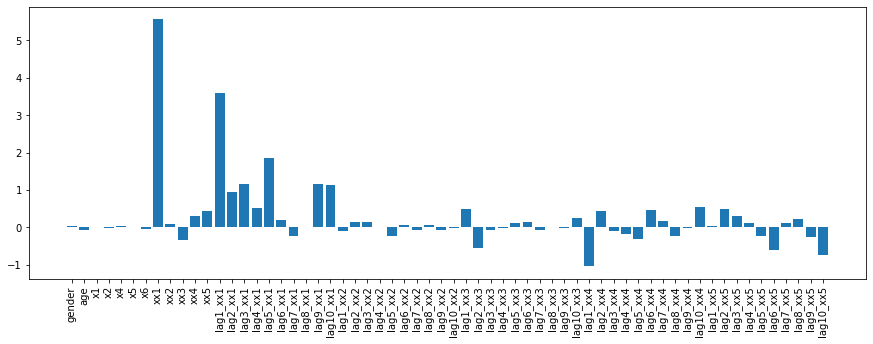

In [38]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=90)
plt.bar(features , model.coef_)

> test model

In [425]:
train_score, test_score = get_cross_validation(model, X_train, y_train['y_mean_HR'], X_val,
                                               y_val['y_mean_HR'], X_test, y_test['y_mean_HR']
                         , mode='test',
                        use_full=False)
print(f"train_score/test_score = {train_score}/{test_score}")

train_score/test_score = 0.9225858004511253/0.9323528735098146


> Use train + val data for training

In [426]:
train_score, test_score = get_cross_validation(model, X_train, y_train['y_mean_HR']
                                               , X_val, y_val['y_mean_HR'], 
                                               X_test, y_test['y_mean_HR']
                         , mode='test',
                        use_full=True)
print(f"train_score/test_score = {train_score}/{test_score}")

train_score/test_score = 0.9233389059446697/0.9323528050826447


<BarContainer object of 18 artists>

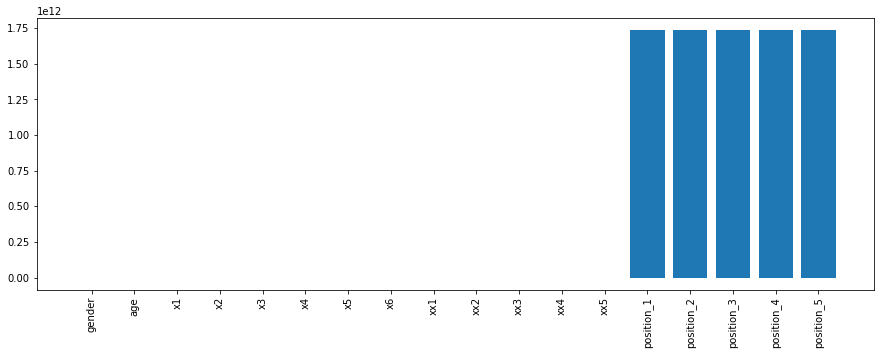

In [427]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=90)
plt.bar(features , model.coef_)

In [309]:
(0.942 + 0.8633)/2

0.90265

In [522]:
from tensorly.regression im

     |████████████████████████████████| 71kB 2.6MB/s eta 0:00:01
     |████████████████████████████████| 163kB 6.9MB/s eta 0:00:01
  Created wheel for tensorly: filename=tensorly-0.4.5-cp36-none-any.whl size=100154 sha256=5951078c5cac6485677d611bd5eac3f763b8a419d09d7f564545b182703eb5ac
  Stored in directory: /Users/nithish/Library/Caches/pip/wheels/44/ae/02/8d00229a4fd0af192b48d24da903f9975c7ac10e706685fc39
Successfully built tensorly


In [ ]:
# gp = df.groupby(['patient_id', 'key'],as_index=False)

# df_with_corr = []
# for key,group in gp:
#     arr1 = group.iloc[-1].values
#     arr_ = np.triu(group[['xx1', 'xx2', 'xx3', 'xx4', 'xx5']].corr()).ravel()
#     arr_ = arr_[[1,2,3,4,7,8,9,13,14,19]]
#     com = np.concatenate([arr1, arr_])
#     df_with_corr.append(com)

# with open('./data/df_with_corr.pickle','wb') as f:
#     pickle.dump(df_with_corr, f)

    
# # with open('./data/df_with_corr.pickle','rb') as f:
# #     df_with_corr = pickle.load(f)

# df_with_corr = pd.DataFrame(df_with_corr)